<a href="https://colab.research.google.com/github/ezrafield/ibm-certificate-final/blob/main/corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harris Corner Detector Implementation
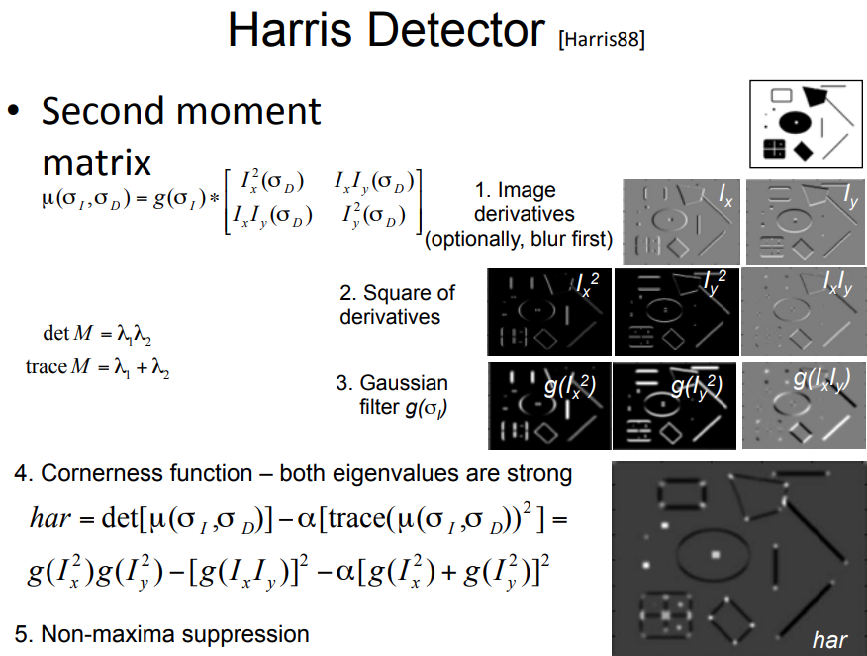

Tham khảo tại: https://www.kaggle.com/code/dasmehdixtr/harris-corner-detector-example-from-scratch

## Import

In [1]:
import numpy as np
import cv2
# chúng ta sẽ build thuật toán từ scrath nên chỉ dùng cv2 để triển khai ảnh thành dataframe
import matplotlib.pyplot as plt
# Hiển thị từng bước biến đổi

## kernel defined

### Sobel x-axis kernel
dùng để đạo hàm theo trục x, đạo hàm phải vì ta xét ảnh từ trái qua phải

In [2]:
SOBEL_X = np.array((
    [-2, 0, 2],
    [-3, 0, 3],
    [-2, 0, 2]),
    dtype = "int32"
)

### Sobel y-axis kernel
dùng để đạo hàm theo trục y, đạo hàm dưới vì ta xét ảnh từ trên xuống dưới

In [3]:
SOBEL_Y = np.array((
    [-2, -3, -2],
    [0, 0, 0],
    [2, 3, 2]),
    dtype = "int32"
)

### Gaussian kernel
phân phối chuẩn, làm mờ ảnh, lây lan độ sáng quanh các edge

In [4]:
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]),
    dtype = "float64"
)

## Convolution function
Convolution layer cho matrix và kernel

In [5]:
def convolution(img, kernel):
  if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
    raise ValueError ("Only odd dimensions on filter supported")

  #shape
  img_height = img.shape[0]
  img_width = img.shape[1]
  pad_height = kernel.shape[0] // 2 # tính từ tâm
  pad_width = kernel.shape[1] // 2 # tính từ tâm

  pad = ((pad_height, pad_height), (pad_height, pad_width))
  output_matrix = np.empty(img.shape, dtype = np.float64)
  img = np.pad(img, pad, mode = 'constant', constant_values = 0)
  # convolution
  for i in np.arange(pad_height, img_height + pad_height):
    for j in np.arange(pad_width, img_width + pad_width):
      roi = img[i - pad_height : i + pad_height + 1, j - pad_width : j + pad_width + 1]
      output_matrix[i - pad_height, j - pad_width] = (roi * kernel).sum()
  
  # check int value
  if (output_matrix.dtype == np.float64):
    kernel = kernel / 255.0
    kernel = (kernel * 255).astype(np.uint8)
  else:
    output_matrix = output_matrix + abs(np.amin(output_matrix))
    output_matrix = output_matrix / np.amax(output_matrix)
    output_matrix = (output_matrix * 255.0)
  
  return output_matrix


## Haris corner detection
image.png

So với threshold

In [6]:
k = 0.13

def harris(img, threshold = 0.6, backgrough = "black"):
  # img preprocessing
  img_copy = img.copy()
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  dx = convolution(img_gray, SOBEL_X) # đạo hàm theo x
  dy = convolution(img_gray, SOBEL_Y) # đạo hàm theo y
  dx2 = np.square(dx)
  dy2 = np.square(dy)
  dxdy = dx * dy
  # làm mờ để bằng gaussian để tăng tỉ lệ phát hiện corner 
  g_dx2 = convolution(dx2, GAUSS)
  g_dy2 = convolution(dy2, GAUSS)
  g_dxdy = convolution(dxdy, GAUSS)
  
  # Haris corner algorithm
  harris = g_dx2 * g_dy2 - np.square(g_dxdy) - k * np.square(g_dx2 + g_dy2)

  #Normalize
  cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)

  # threshold
  if backgrough == "black":
    loc = np.where(harris >= threshold)
  elif backgrough == "white":
    loc = np.where(harris <= 1 - threshold)
  
  # khoanh tròn điểm chọn
  for pt in zip(*loc[::-1]):
    cv2.circle(img_copy, pt, 3, (0, 255, 0), -1)

  return img_copy, g_dx2, g_dy2, dx, dy, loc, img_gray


## Read data

In [7]:
import urllib
import numpy as np

req = urllib.request.urlopen('https://as1.ftcdn.net/v2/jpg/04/18/91/88/1000_F_418918891_mCxkeOmpkoz4sdWNp7uxEH37wx77rEcT.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)

## Apply model

In [8]:
corners,g_dx2,g_dy2,dx,dy,loc, img_gray = harris(img, 0.8, "black")

## non-maximun suppression

## Display

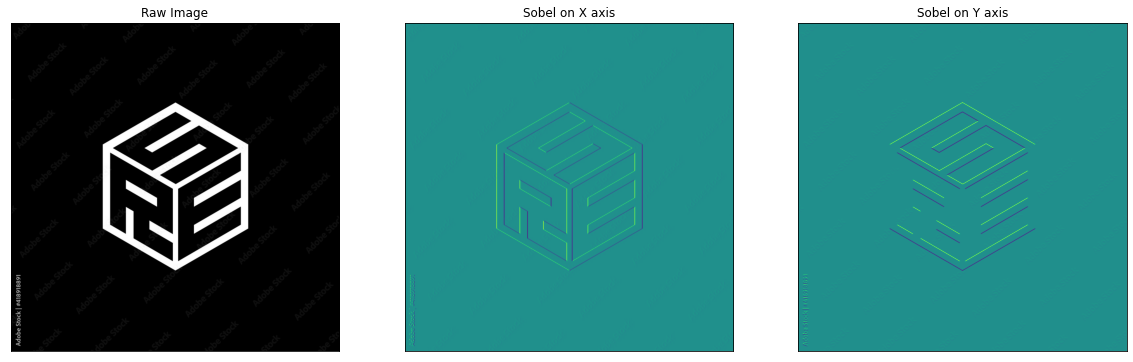

In [9]:
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(dx)
plt.title("Sobel on X axis"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(dy)
plt.title("Sobel on Y axis"), plt.xticks([]), plt.yticks([])
plt.show()

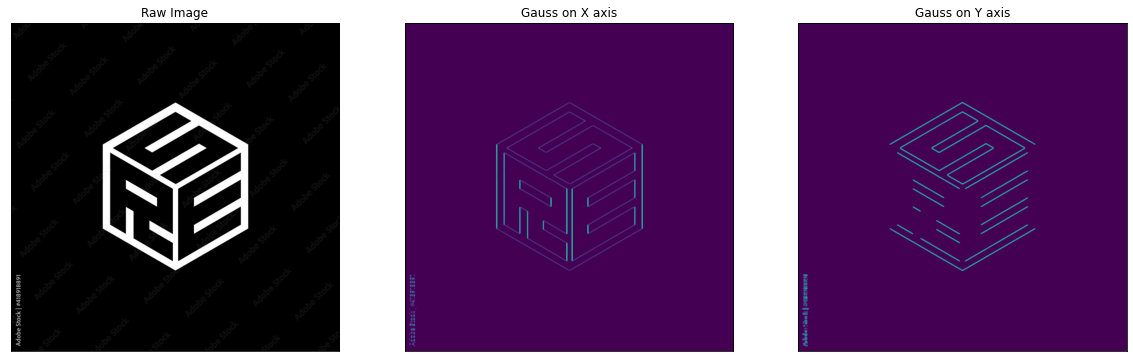

In [10]:
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(g_dx2)
plt.title("Gauss on X axis"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(g_dy2)
plt.title("Gauss on Y axis"), plt.xticks([]), plt.yticks([])
plt.show()

## Result

(Text(0.5, 1.0, 'Harris Corner Output'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

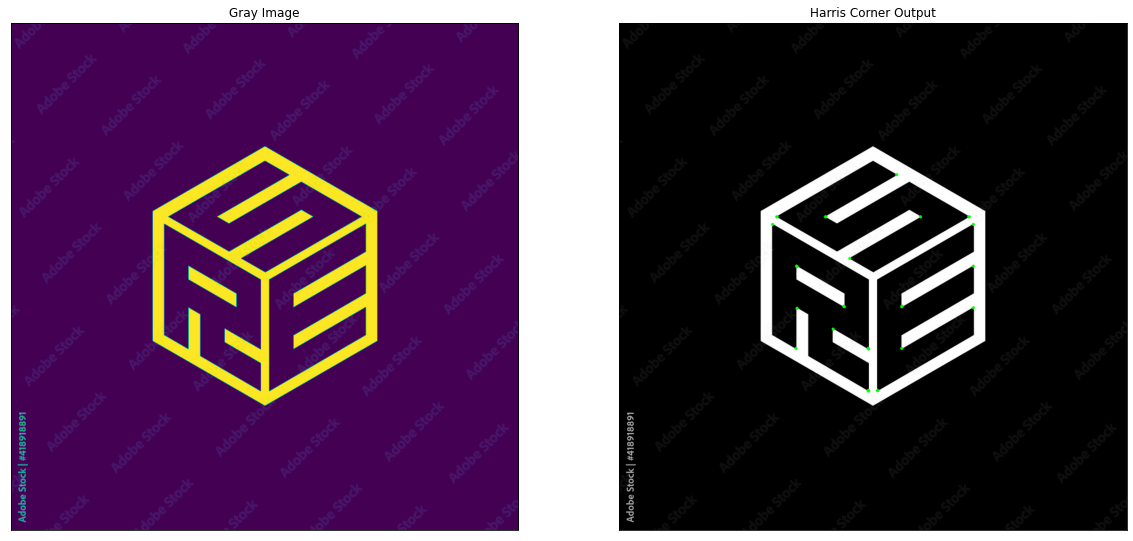

In [11]:
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img_gray)
plt.title("Gray Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(corners)
plt.title("Harris Corner Output"), plt.xticks([]), plt.yticks([])

## Với ảnh inverted

In [12]:
inverted_image = cv2.bitwise_not(img)

In [13]:
cornersi,g_dx2i,g_dy2i,dxi,dyi,loci, img_grayi = harris(inverted_image, 0.8, "white")

(Text(0.5, 1.0, 'Harris Corner Output'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

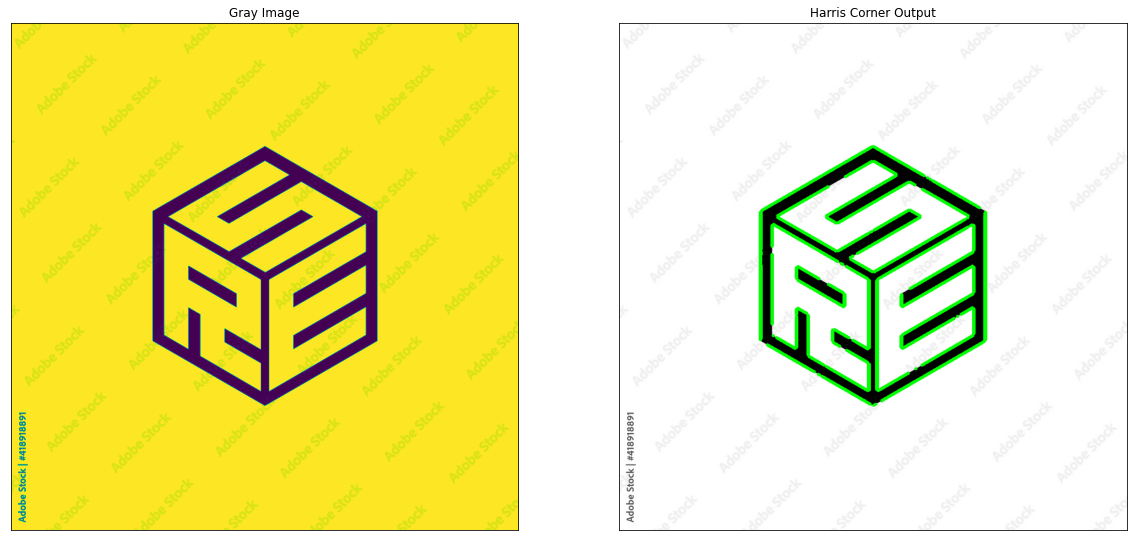

In [14]:
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img_grayi)
plt.title("Gray Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cornersi)
plt.title("Harris Corner Output"), plt.xticks([]), plt.yticks([])

# Sử dụng OpenCV lib

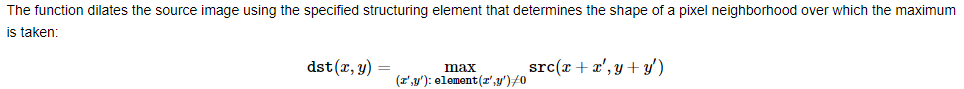

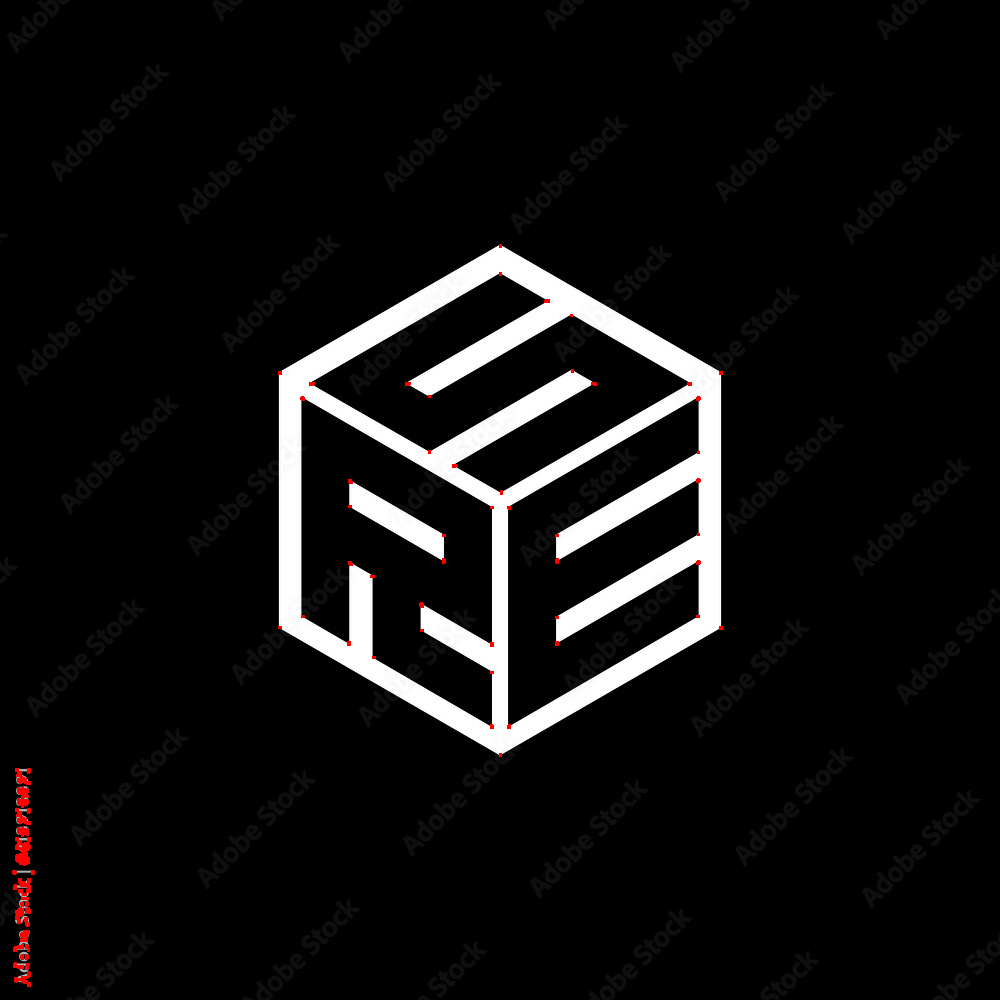

In [22]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
""" cornerHarris	(	
  InputArray 	src,
  int 	ksize,
  int 	blockSize,
  float 	k [, dst[, borderType]
  )	
""" 

dst = cv2.dilate(dst,None) # làm loan màu, tác dụng như gauss
# Threshold
img2 = img.copy()
img2[dst>0.01*dst.max()]=[0,0,255]

from google.colab.patches import cv2_imshow
cv2_imshow(img2)

## Với ảnh ngược màu

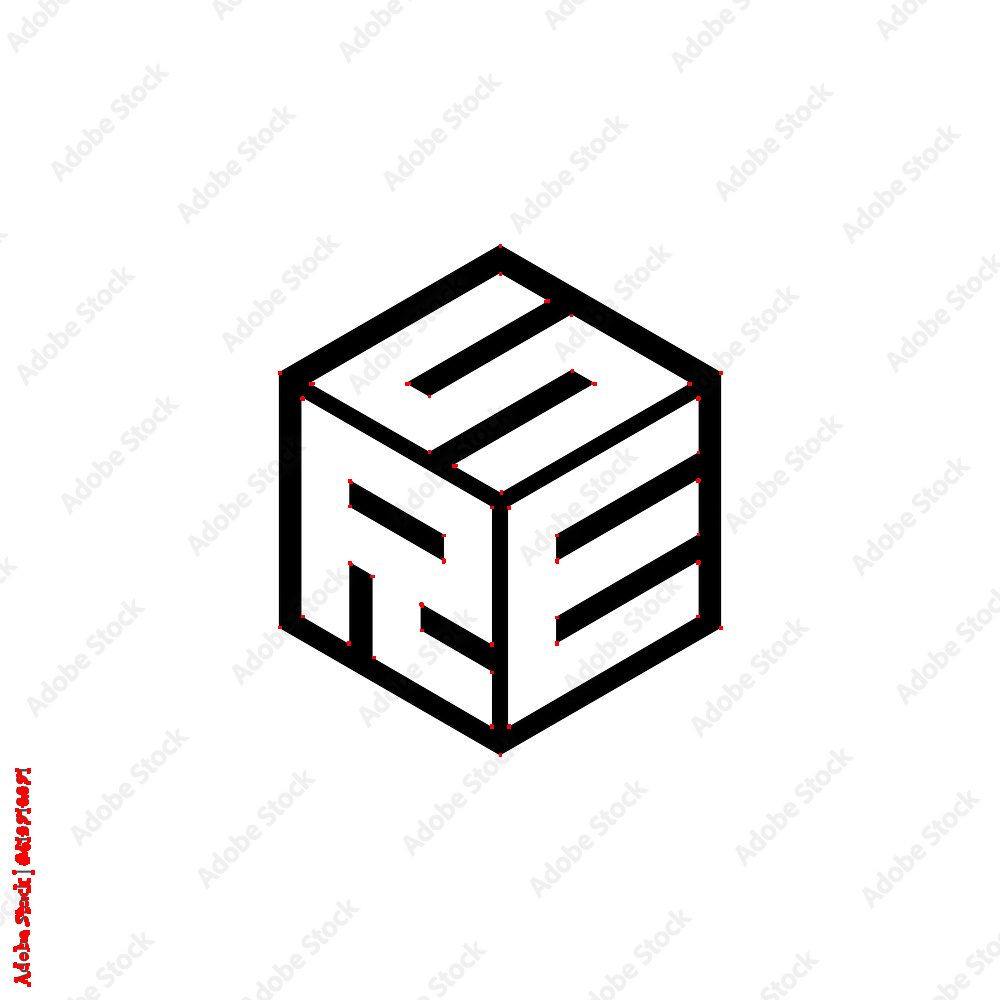

In [23]:
# inverted_image
gray = cv2.cvtColor(inverted_image,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
""" cornerHarris	(	
  InputArray 	src,
  int 	ksize,
  int 	blockSize,
  float 	k [, dst[, borderType]
  )	
""" 

dst = cv2.dilate(dst,None) # làm loan màu, tác dụng như gauss
# Threshold
inverted_image2 = inverted_image.copy()
inverted_image2[dst>0.01*dst.max()]=[0,0,255]

cv2_imshow(inverted_image2)